<p align="left">
  <img src="gwfish-1.png" width="200" title="Logo">
</p>

# Fun with Priors
## A tutorial on how to add priors to your Fisher matrix results

When using the Fisher matrix analysis to process your GW data, you are not making any assumptions on the range the parameters are supposed to physically be in. As an example, one may get as a result from GWFish that the uncertainty on the inclination angle, which range is in $[0, \pi]$ is a number leading out of the parameter range. Therefore, one may implement in post-processing the prior information and re-calculate the covariance matrix and thus the new (thighter) constraints on the uncertainty.

**Pay attention to the fact that after applying your filtering with priors, the samples are no longer following the Gaussian distribution!**

## Add relevant packages

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import GWFish.modules as gw

## Load data

In [2]:
path_to_means_file = 'test_data/Errors_ET_BBH_SNR8.0.txt'
path_to_cov_mat_file = 'test_data/Inv_Fishers_ET_BBH_SNR8.0.npy'

mns_data_lbs = ['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'redshift', 
                'dec', 'ra', 'theta_jn', 'psi', 'geocent_time', 'phase', 'err_mass_1',
                'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
                'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
mns_data = pd.read_csv(path_to_means_file, names = mns_data_lbs, delimiter = ' ',
                        low_memory = False, skiprows = 1)
cov_data = np.load(path_to_cov_mat_file)
mns_data

,network_SNR,mass_1,mass_2,luminosity_distance,redshift,dec,ra,theta_jn,psi,geocent_time,...,err_mass_1,err_mass_2,err_luminosity_distance,err_dec,err_ra,err_theta_jn,err_psi,err_geocent_time,err_phase,err_sky_location
0,250.562037,5.968591,5.341823,129.2411,0.0285,1.214201,-0.490508,5.243474,1.775011,2.538233,...,0.009246,0.008109,21.462670,0.026680,0.020751,0.063247,0.072402,0.000427,0.205058,0.001504
1,414.969202,10.183302,8.326101,166.4255,0.0365,2.044109,-0.584800,1.604565,3.803508,1.349997,...,0.006283,0.004966,29.123599,0.033843,0.069500,0.081324,0.145329,0.000683,0.319853,0.006103
2,1647.799564,19.766036,17.484118,108.9691,0.0242,1.764933,0.396620,5.230095,5.187390,2.552551,...,0.007537,0.006561,22.616646,0.264988,0.372759,0.014351,0.220102,0.004537,0.023384,0.281948
3,676.498869,24.054061,15.926772,124.6226,0.0276,1.409720,-0.628034,3.153255,1.177076,1.765002,...,0.007253,0.004559,23.179110,0.033662,0.047823,0.042285,0.119993,0.000652,0.065273,0.003937
4,2939.230468,16.924587,16.713585,53.8830,0.0120,1.845102,1.535545,4.809496,1.492174,5.532838,...,0.013844,0.013647,3.688323,0.069941,2.453719,0.010765,2.461068,0.001445,0.026346,0.018325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,236.346328,18.358807,16.476386,778.1483,0.1577,2.080775,-1.209182,4.068978,1.017228,2.928698,...,0.053391,0.047212,297.745048,0.323378,0.566134,0.098572,0.714908,0.005199,0.592804,0.152207
96,293.596732,17.585949,15.460710,784.1039,0.1588,0.059967,0.183726,0.254073,3.099249,3.291336,...,0.034529,0.029812,7.321578,0.002930,0.002980,0.133087,0.001922,0.000060,0.003851,0.000027
97,369.303387,18.599501,10.529628,862.1453,0.1731,2.303891,0.655266,1.874483,5.123685,0.083207,...,0.008999,0.004825,203.506531,4.526501,1.340025,0.012261,0.891995,0.005036,0.037382,14.690556
98,115.494419,13.653922,12.244591,837.4635,0.1686,1.140348,-0.755940,2.464379,4.711146,5.933943,...,0.066087,0.058274,620.332712,0.210847,0.496928,0.261933,0.029119,0.005286,1.152725,0.220016


First one needs to create a vector of the mean values. This can be taken from the Errors.txt file, taking into consideration the right order in which these parameters appear in the covariance matrix (it is the same order of the err_<param_name> columns in Errors.txt file)

In [3]:
# List the parameters as they appear in the covariance matrix
var_in_cov_matrix = ['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
                    'theta_jn', 'psi', 'geocent_time', 'phase']
# Take the corresponding columns to create the vector of mean values
mns = mns_data[var_in_cov_matrix]
mns

,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,geocent_time,phase
0,5.968591,5.341823,129.2411,1.214201,-0.490508,5.243474,1.775011,2.538233,1.105117e+09
1,10.183302,8.326101,166.4255,2.044109,-0.584800,1.604565,3.803508,1.349997,1.133568e+09
2,19.766036,17.484118,108.9691,1.764933,0.396620,5.230095,5.187390,2.552551,1.107329e+09
3,24.054061,15.926772,124.6226,1.409720,-0.628034,3.153255,1.177076,1.765002,1.126940e+09
4,16.924587,16.713585,53.8830,1.845102,1.535545,4.809496,1.492174,5.532838,1.111366e+09
...,...,...,...,...,...,...,...,...,...
95,18.358807,16.476386,778.1483,2.080775,-1.209182,4.068978,1.017228,2.928698,1.128328e+09
96,17.585949,15.460710,784.1039,0.059967,0.183726,0.254073,3.099249,3.291336,1.135562e+09
97,18.599501,10.529628,862.1453,2.303891,0.655266,1.874483,5.123685,0.083207,1.133402e+09
98,13.653922,12.244591,837.4635,1.140348,-0.755940,2.464379,4.711146,5.933943,1.106507e+09


In [4]:
# Store the value of the total number of events and 
# of the number of parameters considered for each event
ns = len(mns)
npar = len(var_in_cov_matrix)

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    sky_localization = np.zeros((ns,)) #new vector for sky localization
    # Store the index number where 'ra' and 'dec' are to calculate the new
    # sky localization
    idx_ra = var_in_cov_matrix.index('ra')
    idx_dec = var_in_cov_matrix.index('dec')

## Sample from the Gaussian distribution and apply priors

In [5]:
import warnings
warnings.filterwarnings("ignore")

# choose event
k = 98
mns_ev = mns.iloc[k]
cov_ev = cov_data[k, :, :]

# number of points to sample from the gaussian
number_of_samples = 1e6 
samples = np.random.multivariate_normal(mns_ev, np.squeeze(cov_ev), int(number_of_samples))

# Create samples dataframe to pass thruogh priors masks
data_samples = {'mass_1':samples[:, 0],
        'mass_2':samples[:, 1],
        'luminosity_distance':samples[:, 2],
        'dec':samples[:, 3],
        'ra':samples[:, 4],
        'theta_jn':samples[:, 5],
        'psi':samples[:, 6],
        'geocent_time':samples[:, 7],
        'phase':samples[:, 8]}
data = pd.DataFrame(data = data_samples)

# Choose which priors to combine
mask_dist = gw.priors.distance_prior(data)
mask_iota = gw.priors.iota_prior_uniform(data)
mask_ra = gw.priors.ra_prior(data)
mask_dec = gw.priors.dec_prior_uniform(data)
mask = np.logical_and(np.logical_and(mask_dist, mask_iota), np.logical_and(mask_ra, mask_dec))

# Or directly apply priors to all the parameters
#mask = gw.priors.uniform_priors(data)

# Filter data samples
data_filtered = data.loc[mask]
new_cov = np.cov((data_filtered.to_numpy()).T)
new_parameter_errors = np.sqrt(np.diagonal(new_cov))

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    sky_localization = np.pi * np.abs(np.cos(mns_ev[idx_dec])) *\
                        np.sqrt(new_cov[idx_ra, idx_ra] * new_cov[idx_dec, idx_dec]\
                        - new_cov[idx_ra, idx_dec]**2)
    new_parameter_errors = np.append(new_parameter_errors, sky_localization)

In [6]:
err_columns = ['err_mass_1', 'err_mass_2', 'err_luminosity_distance', 'err_dec', 
                     'err_ra', 'err_theta_jn', 'err_psi', 'err_geocent_time', 'err_phase',
                     'err_sky_location']
errors_before = mns_data[err_columns]
errors_before.iloc[k].to_numpy()

array([6.60870000e-02, 5.82740000e-02, 6.20332712e+02, 2.10847000e-01,
       4.96928000e-01, 2.61933000e-01, 2.91190000e-02, 5.28600000e-03,
       1.15272500e+00, 2.20016000e-01])

In [7]:
errors_after = new_parameter_errors
errors_after

array([6.59092712e-02, 5.81142490e-02, 4.32980966e+02, 1.68701839e-01,
       1.85084274e-01, 2.19955756e-01, 1.86610462e-02, 2.74485246e-03,
       4.54075271e-01, 4.05581685e-02])

## Corner plot to compare results with and without priors

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner

CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = False, # choose if you want datapoints
    label_kwargs = dict(fontsize = 16), # font size for labels
    show_titles = False, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = False, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )

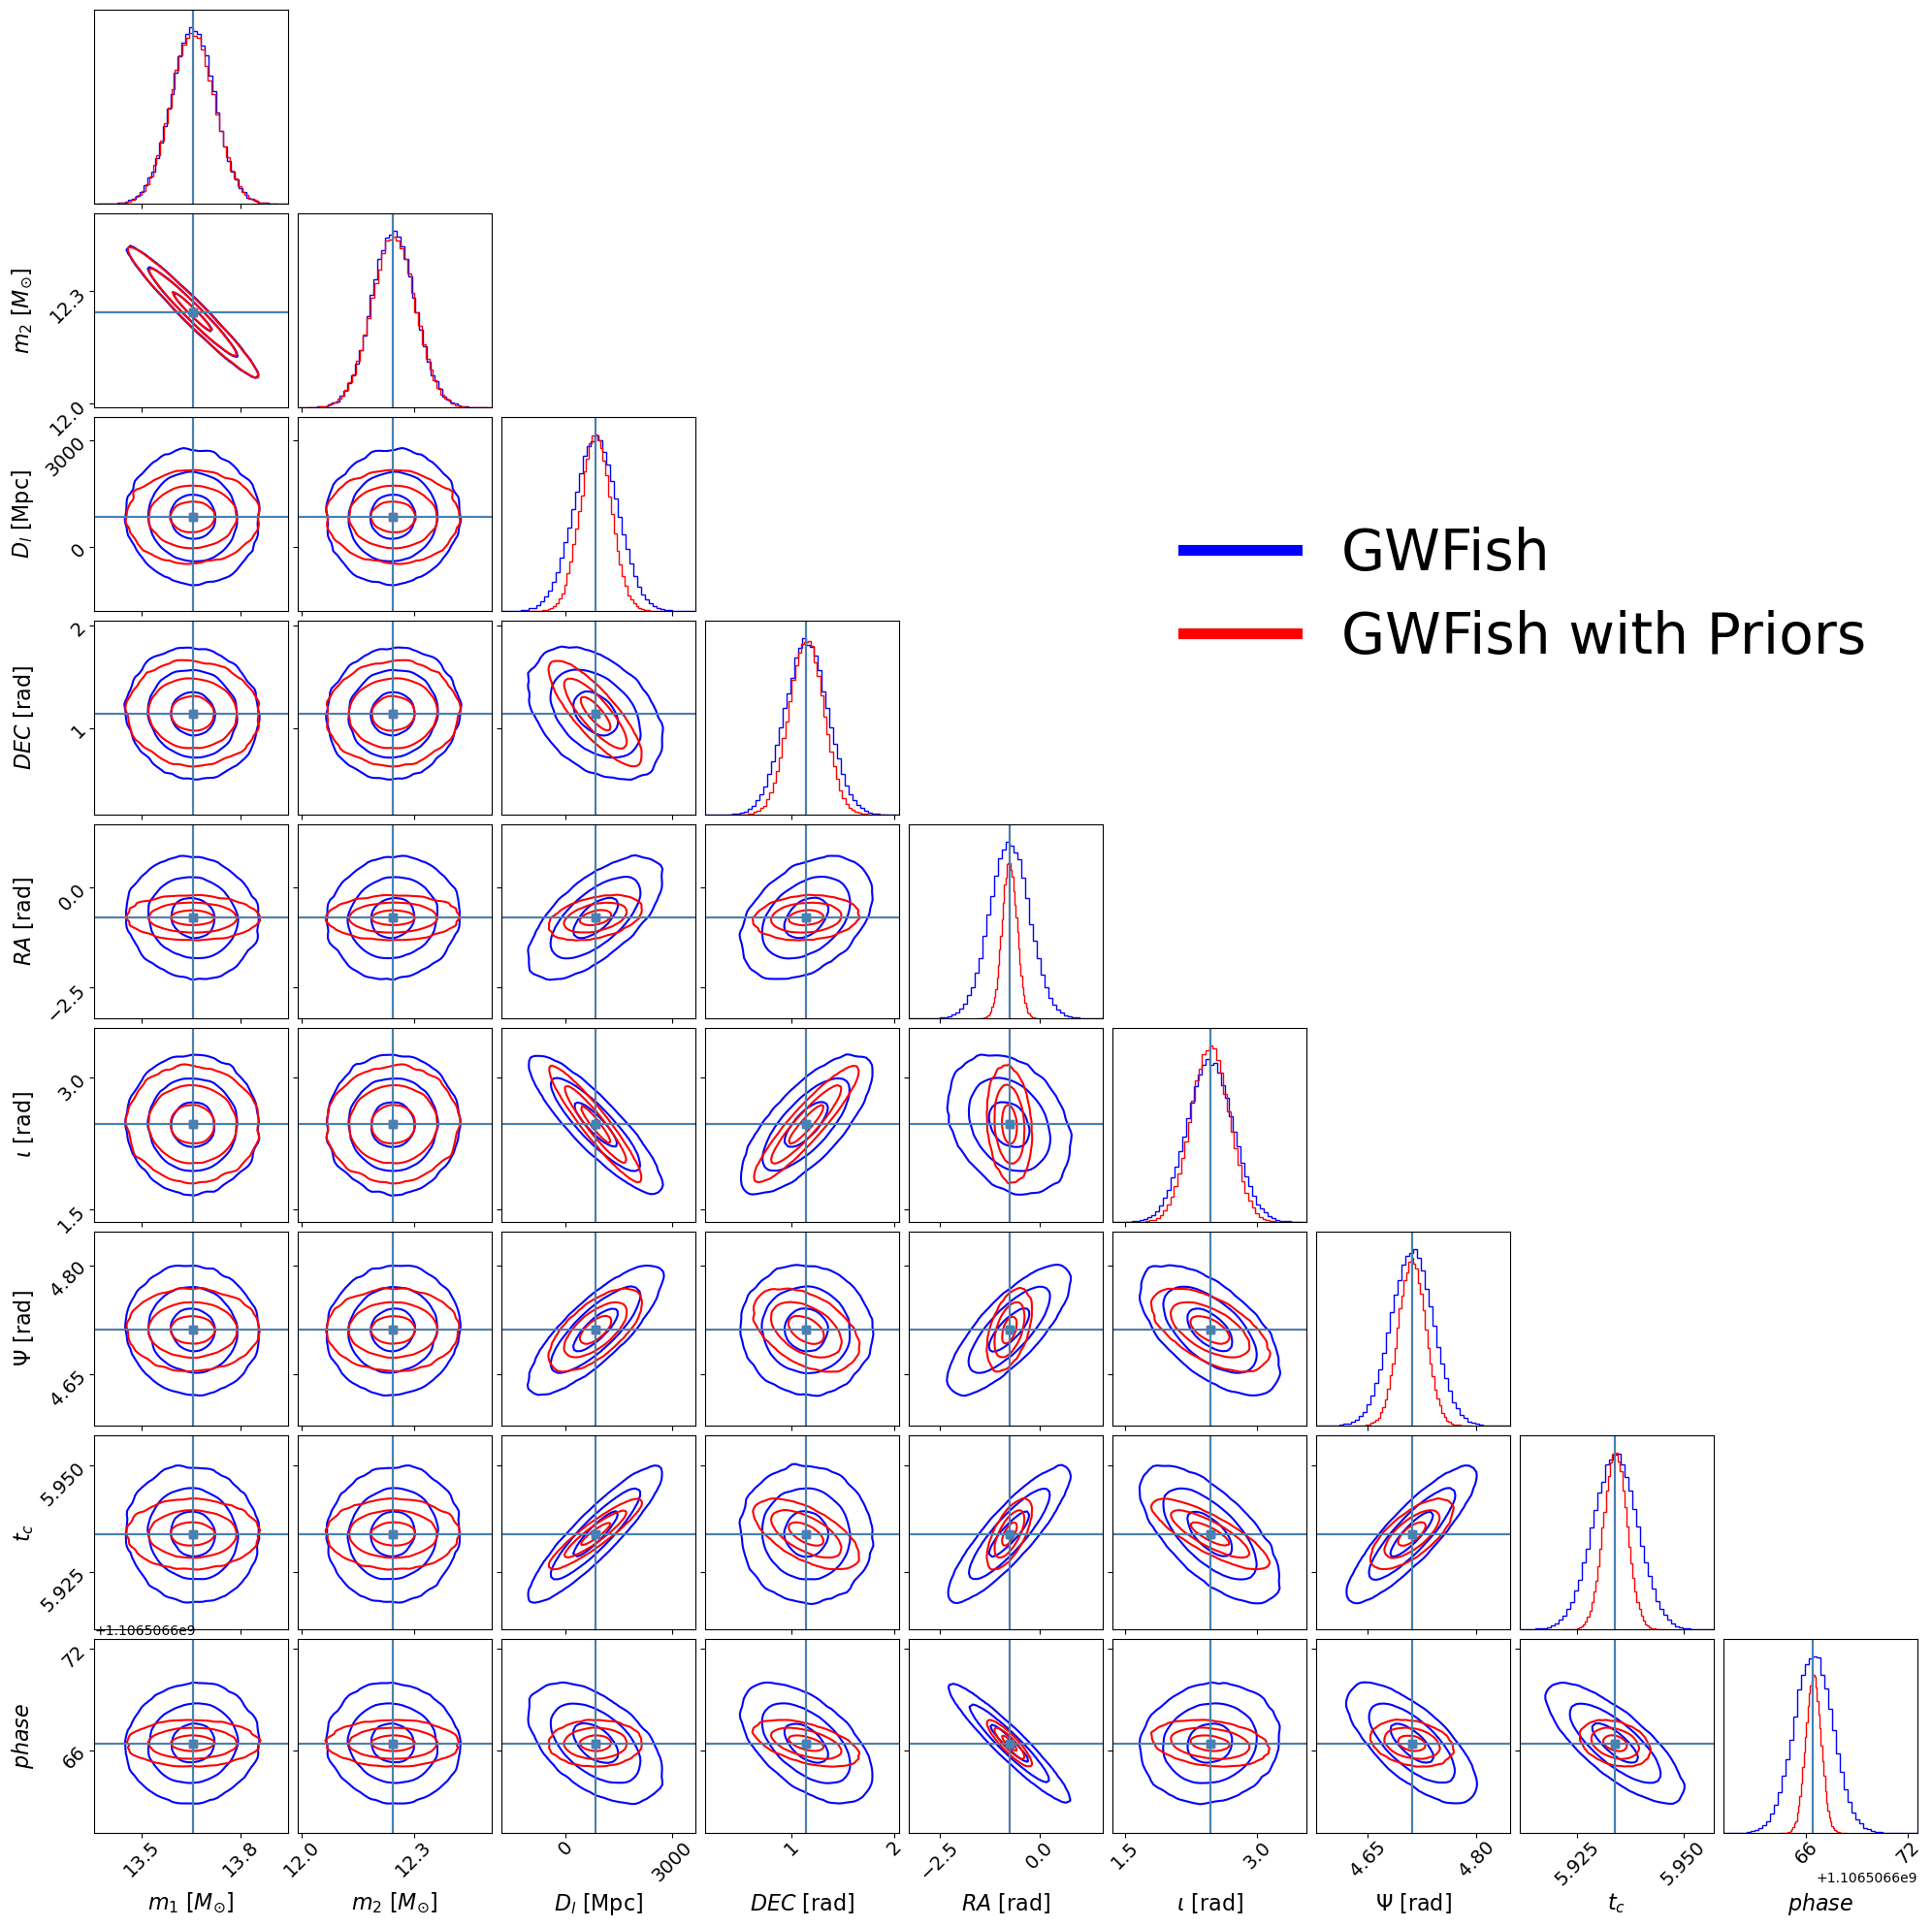

In [9]:
corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]',
                '$DEC$ [rad]', '$RA$ [rad]', '$\iota$ [rad]', '$\Psi$ [rad]',
                '$t_c$', '$phase$']
mean_values = mns_ev
cov_matrix = cov_ev
prior_cov_matrix = new_cov
# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e5))
samples_prior = np.random.multivariate_normal(mean_values, prior_cov_matrix, int(1e5))


colors = ['blue', 'red']
sample_labels = ['GWFish', 'GWFish with Priors']
fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    color = colors[0], **CORNER_KWARGS)
fig = corner.corner(samples_prior, fig = fig, truths=mean_values, color = colors[1],
                     **CORNER_KWARGS)
for ax in fig.get_axes():
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14, pad = 0.1)
plt.legend(
        handles = [
            mlines.Line2D([], [], linewidth=8, color=colors[i], label = sample_labels[i])
            for i in range(2)
        ],
        fontsize = 42, frameon = False,
        bbox_to_anchor = (1, 7), loc = "upper right"
    )
plt.show()

If you want to apply priors to an entire population just cycle over the events and save the new errors and covariance data. Or directly use **the script CBC_Prior.py**

In [10]:
new_cov = np.zeros((ns, npar, npar))
new_parameter_errors = np.zeros((ns, npar))

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    sky_localization = np.zeros((ns,))


number_of_samples = 1e6

for k in tqdm(np.arange(ns)):
    mns_ev = np.array(mns.iloc[k])
    cov_ev = cov_data[k, :, :]
    samples = np.random.multivariate_normal(mns_ev, np.squeeze(cov_ev), int(number_of_samples))

    data_samples = {'mass_1':samples[:, 0],
            'mass_2':samples[:, 1],
            'luminosity_distance':samples[:, 2],
            'dec':samples[:, 3],
            'ra':samples[:, 4],
            'theta_jn':samples[:, 5],
            'psi':samples[:, 6],
            'geocent_time':samples[:, 7],
            'phase':samples[:, 8]}
    data = pd.DataFrame(data = data_samples)
    
    # Consider just the prior on distance and inclination angle
    mask_dist = gw.priors.distance_prior(data)
    mask_iota = gw.priors.iota_prior_uniform(data)
    mask = np.logical_and(mask_dist, mask_iota)


    # Filter data samples
    data_filtered = data.loc[mask]
    new_cov[k, :, :] = np.cov((data_filtered.to_numpy()).T)
    new_parameter_errors[k, :] = np.sqrt(np.diagonal(new_cov[k, :, :]))

    if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
        sky_localization[k] = np.pi * np.abs(np.cos(mns_ev[idx_dec])) *\
                            np.sqrt(new_cov[k, idx_ra, idx_ra] * new_cov[k, idx_dec, idx_dec]\
                            - new_cov[k, idx_ra, idx_dec]**2)

np.save('test_data/New_Cov_Matrices.npy', new_cov)

if ('ra' in var_in_cov_matrix) and ('dec' in var_in_cov_matrix):
    data_to_save = np.c_[mns, new_parameter_errors, sky_localization]
    header = 'mass_1, mass_2, luminosity_distance, dec, ra, theta_jn, psi, geocent_time, phase,err_mass_1, err_mass_2, err_luminosity_distance, err_dec, err_ra, err_theta_jn, err_psi, err_geocent_time, err_phase, err_sky_loc'
    np.savetxt('test_data/New_Errors.txt', data_to_save, delimiter=' ', fmt='%.8f', header=header, comments='')
else:
    data_to_save = np.c_[mns, new_parameter_errors]
    header = 'mass_1, mass_2, luminosity_distance, dec, ra, theta_jn, psi, geocent_time, phase,err_mass_1, err_mass_2, err_luminosity_distance, err_dec, err_ra, err_theta_jn, err_psi, err_geocent_time, err_phase'
    np.savetxt('test_data/New_Errors.txt', data_to_save, delimiter=' ', fmt='%.8f', header=header, comments='')


100%|███████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]


In [11]:
err_lbs = ['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 
        'theta_jn', 'psi', 'geocent_time', 'phase', 'err_mass_1',
        'err_mass_2', 'err_luminosity_distance', 'err_dec', 'err_ra', 'err_theta_jn',
        'err_psi', 'err_geocent_time', 'err_phase', 'err_sky_location']
new_errors = pd.read_csv('test_data/New_Errors.txt', names = err_lbs, delimiter = ' ',
                        low_memory = False, skiprows = 1)

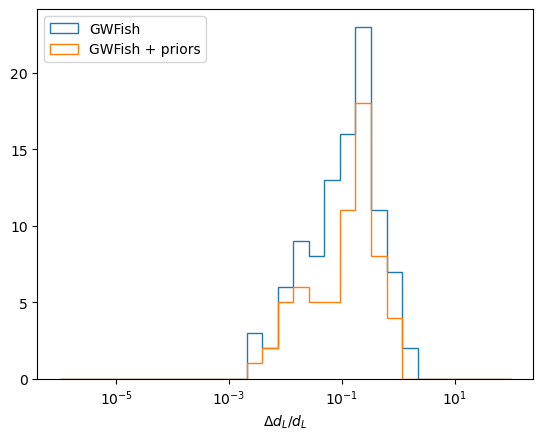

In [12]:
my_bins = np.logspace(-6, 2, 30)
plt.hist(mns_data['err_luminosity_distance']/mns_data['luminosity_distance'], 
         bins = my_bins, histtype = 'step', label = 'GWFish')
plt.hist(new_errors['err_luminosity_distance']/new_errors['luminosity_distance'], 
         bins = my_bins, histtype = 'step', label = 'GWFish + priors')
plt.legend()
plt.xlabel('$\Delta d_L / d_L$')
plt.xscale('log')
plt.show()

Pay attention that for some events the suggested number of samples may not be enough, so that after applying the priors there are no points left with which to calculate the new covariance matrix!